# CS 105 Final Project

**Team**: Thomas Henningson, Josh Pennington, Suhail-Anand Dhilon, Cameron Tsai <br><br>

# Introduction

**State a question or set a goal. How can you answer your questions or achieve your goal?**

We want to reduce the size of an image database while reducing the amount of information loss in each image. 

We will reduce the size of the database by clustering the pixel values of all the images in the database, and replacing them with their cluster mean. We will use K-means clustering to achieve this. We will try many different cluster values in order to find the smallest k that keeps error to a minimum. We will be using mean squared error between the original pixel values and the cluster averages as our error function.

Once we have found a good k-value, we will use huffman encoding to store the cluster values and compress the dataset. We will need to store each images encoding, as well as an encoding of the tree so that it remembers to cluster averages pixel values. We can then compare the total bits used in the compressed images + tree encoding to the entire dataset to find our compression rate.

**What data do you need? Can you find it?**

We need a basic database of images, preferrably a smaller database with smaller images. This should be relatively easy to find, with databases such as CIFAR-10 and CIFAR-100 existing.

**Find a sufficiently large dataset online**

After some searching, we were able to find the Linnaeus_5 dataset. This dataset contains 128x128 pixel images belonging to 1 of 5 classes: berry, bird, dog, flower, and other. This dataset is typically used for training image classifiers, but it also suits out purposes. There are a total of 1600 images in each class for a total of 8000 images, giving us plent of data to work with.

**Do you need to clean it?**

No, we will not need to clean this dataset, since it already suits out purposes very well. However, we will reduce the size of the dataset by selecting a subset of images from each class. This is so that our code runs in a timely manner. We will shoot to have about 100 images total to test our code on, out of the 8000 available.

In [2]:
import random
import matplotlib.pyplot as plt
import pickle
import numpy as np
from sklearn.cluster import KMeans
from dahuffman import HuffmanCodec

In [21]:
data = []
classes = ["berry", "bird", "dog", "flower", "other"]

for c in classes:
    samp = random.sample(range(1,1201), 20)
    for x in samp:
        image = plt.imread("Linnaeus_5/train/%s/%d_128.jpg"%(c,x))
        pic = image.reshape(128*128*3)
        data.append(pic)

# change to True to get new dataset
if False:
    with open('images.data', 'wb') as f:
        pickle.dump(data, f)

# Exploratory Data Analysis

Our dataset is pretty straightforward, so we will not need to explore as much. Let us start by visualizing an example image from the dataset.

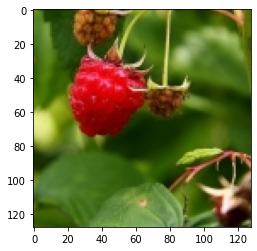

In [23]:
with open('images.data', 'rb') as f:
    data = pickle.load(f) # retrieve image data

data = np.array(data)
data = np.reshape(data, (100,128,128,3)) # reshape into images

pic = data[random.randint(0, 99)]
plt.imshow(pic) # plot a random image
plt.show()

As we can see, there is a 128x128 image using RGB color channels. If we print the first pixel of this same image, we can see the range of the RGB channels (whether it is 0-255 or 0-1)

In [23]:
print(pic[0][0])

[174 178   6]


Since these are integer value, we know the range of the RGB channels is 0-255.

Essentially, this is all we need to know about our dataset in order to implement K-means clustering.

# Finding a good cluster values

Our algorithm is a two step process, which uses K-means clustering in each step. First, we want to seperate our database of images into different groups which have relatively similar colors. We will do this by clustering the average pixel value of an entire image for all images in the set. We will call this cluster value G, and it is the number of groups the database has been split into, and will therefore be the total number of huffman trees we will have to encode.

The next step will be to cluster all images in each group using all pixel values of every image belonging to said group. This is the meat of the algorithm. We will call this cluster value K. This will be the number of pixel values that will replace the original values in the groups images. K determines the number of leaf nodes in the huffman tree.

Let us start with step one and determine the value of G we should use.

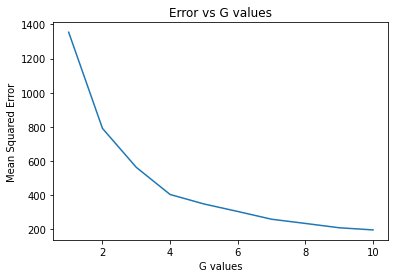

In [24]:
with open('images.data', 'rb') as f:
    data = pickle.load(f)

orig_data = np.array(data) # retrieve image data

imgs = np.reshape(orig_data, (100,128*128,3)) # reshape data to get RGB channels
averages = np.mean(imgs, axis=1) # average along each images RGB

G_vals = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] # clusters for average pixel values

tot_err = []
for g in G_vals:
    kmeans = KMeans(n_clusters=g, random_state=0).fit(averages) # cluster according to G
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_

    # get list of centers for each average pixel
    error = []
    for i in range(labels.shape[0]):
        error.append(centers[labels[i]])

    # measure error between centers and averages in the cluster
    mse = (np.square(averages - error)).mean(axis=None)
    tot_err.append(mse)

# plot error over G values
plt.plot(G_vals, tot_err)
plt.title("Error vs G values")
plt.xlabel("G values")
plt.ylabel("Mean Squared Error")
plt.show()

Based on this plot, we want to find the "Elbow" to determine our G value. This is a subjective process, but it seems to us that the elbow of this graph is G=4. We will continue with this G value as our value.

Now we can begin step 2 and find a good K-value. First, we will split the database into the groups we found before, and then we will test many different k-values on each of the groups. We will then plot the same error graphs and find the elbow, just as before.

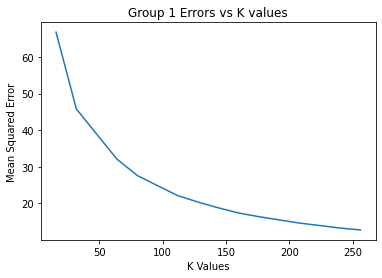

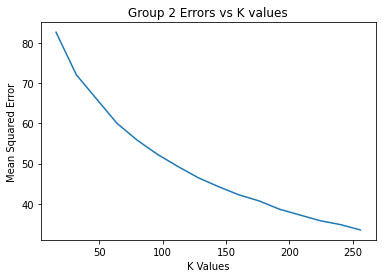

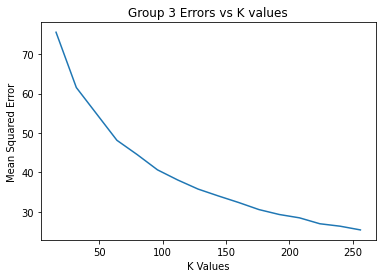

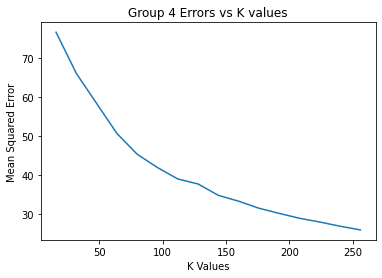

In [27]:
with open('images.data', 'rb') as f:
    data = pickle.load(f)

orig_data = np.array(data) # retrieve image data

imgs = np.reshape(orig_data, (100,128*128,3)) # reshape data to get RGB channels
averages = np.mean(imgs, axis=1) # average along each images RGB

K_vals = [16, 32, 64, 80, 96, 112, 128, 144, 160, 176, 192, 208, 224, 240, 256] # test K values
G = 4 # G value found earlier

kmeans = KMeans(n_clusters=G, random_state=0).fit(averages) # intial group clustering
labels = kmeans.labels_

stratified_data = []
for i in range(G): # stratify images based on intial clustering
    lst = []
    for j,val in enumerate(labels):
        if i == val:
            lst.append(orig_data[j])
    lst = np.array(lst)
    stratified_data.append(lst)

all_error = [] # stores all errors for each cluster value for each batch
for group in stratified_data:
    error = [] # stores error for this specific batch
    for k in K_vals: # for each cluster value
        comp_data = group.copy() # copy the batch and reshape 
        lst = []
        img = np.reshape(comp_data[0], (128*128,3))
        tot = img
        lst.append(img)
        for i in range(1, comp_data.shape[0]): # group all pixels of every image in the batch
            img = np.reshape(comp_data[i], (128*128,3))
            tot = np.concatenate((tot,img))
            lst.append(img)

        # cluster the pixel values
        kmeans = KMeans(n_clusters=k, random_state=0).fit(tot)
        labels = kmeans.labels_
        centers = np.around(kmeans.cluster_centers_)

        # replace pixel values with averages
        for i in range(len(lst)):
            for j in range(128*128):
                lst[i][j] = centers[labels[(i*(128*128))+j]]

        # Error measurement for pics
        mse = (np.square(group - comp_data)).mean(axis=None)
        error.append(mse)

    all_error.append(error) # append errors to all_error

# plot the error for each group
num = 1
for err in all_error:
    plt.plot(K_vals, err)
    plt.title("Group %d Errors vs K values"%(num))
    num += 1
    plt.xlabel("K Values")
    plt.ylabel("Mean Squared Error")
    plt.show()

Again, while it is still subjective, we believe that the elbows of all four of these graphs are around k=100. So, we will use that as are K value going forward. We have now determined the value of K and G to be 100 and 4, respectively. Next, we will compress the data using K and G, and huffman encode the results to achieve a compressed database.

In [3]:
with open('images.data', 'rb') as f:
    data = pickle.load(f)

orig_data = np.array(data) # retrieve image data

imgs = np.reshape(orig_data, (100,128*128,3)) # reshape data to get RGB channels
averages = np.mean(imgs, axis=1) # average along each images RGB

G = 4 # Found G value
K = 100 # Found K value that applies to all groups

kmeans = KMeans(n_clusters=G, random_state=0).fit(averages) # intial group clustering
labels = kmeans.labels_

stratified_data = []
for i in range(G): # stratify images based on intial clustering
    lst = []
    for j,val in enumerate(labels):
        if i == val:
            lst.append(orig_data[j])
    lst = np.array(lst)
    stratified_data.append(lst)

count = 1
for group in stratified_data:
    comp_data = group.copy() # copy the group and reshape 
    lst = []
    img = np.reshape(comp_data[0], (128*128,3))
    tot = img
    lst.append(img)
    for i in range(1, comp_data.shape[0]): # group all pixels of every image in the batch
        img = np.reshape(comp_data[i], (128*128,3))
        tot = np.concatenate((tot,img))
        lst.append(img)

    # cluster the pixel values
    kmeans = KMeans(n_clusters=K, random_state=0).fit(tot)
    labels = kmeans.labels_
    centers = np.around(kmeans.cluster_centers_)

    # replace pixel values with averages, and count cluster frequencies
    freq = np.zeros(K)
    for i in range(len(lst)):
        for j in range(128*128):
            lst[i][j] = centers[labels[(i*(128*128))+j]]
            freq[labels[(i*(128*128))+j]] += 1

    # create a dictionary of cluster averages frequencies
    d = {}
    for i in range(len(freq)):
        # key is all RGB values of average pixels as a string
        # ex. R 45, G 143, B 255 key will be '045143255'
        key = (str(int(centers[i][0])).zfill(3) 
             + str(int(centers[i][1])).zfill(3) 
             + str(int(centers[i][2])).zfill(3))
        d[key] = int(freq[i])

    # Huffman encodes the given frequency dictionary and stores it
    codec = HuffmanCodec.from_frequencies(d)
    HuffmanCodec.save(codec, "Linnaeus_5_compressed/group%d.codec"%(count))

    # set up the list of needed encodings by changing the pixel values of every image in group
    # to the string format described above
    to_encode = []
    for i in range(comp_data.shape[0]):
        pic = np.reshape(comp_data[i], (128*128,3))
        for j in range(pic.shape[0]):
            val = (str(int(pic[j][0])).zfill(3) 
                 + str(int(pic[j][1])).zfill(3) 
                 + str(int(pic[j][2])).zfill(3))
            to_encode.append(val)

    # encodes the list of strings into one big bitstring, which we can store in a bin file
    encoded = codec.encode(to_encode)
    file = open("Linnaeus_5_compressed/group%d.bin"%(count), "wb")
    file.write(encoded)
    file.close()
    count += 1



Now that we have successfully compressed all of the images into huffman encoded binary files, we can compare the sizes of our compression and the original data. The total amount of bytes in our compressed database is: 1287 kB

In comparison, a pickled numpy array of the orignal dataset we have been using to load and store the array so far is 4804 kB

For further comparison, the original JPG images have an average size of 17.1 kB each. Therefore, our set of 100 images is around 1710 kB in size originally.

Therefore, we were able to achieve a 1.33x - 3.73x reduction in the amount of space used by these images.

For a sanity check, we will see if we can sucessfully retrieve the compressed image data from the encoded files we just made. We will print 3 random images to show our success in retrieving the data, as well as to showcase how the images look after the K-means clustering compression.

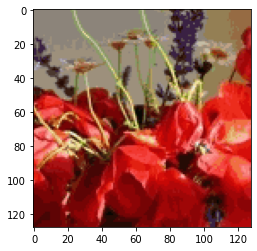

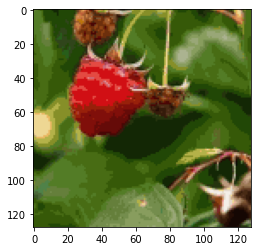

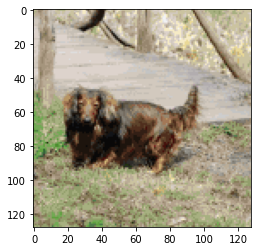

In [6]:
data = []
for i in range(1,5):
    codec = HuffmanCodec.load("Linnaeus_5_compressed/group%d.codec"%(i))
    with open("Linnaeus_5_compressed/group%d.bin"%(i), mode='rb') as file:
        encoded = file.read()

    decoded = codec.decode(encoded)
    numPics = int(len(decoded)/(128*128*9))
    for i in range(numPics):
        pic = []
        for j in range(128*128):
            pix = []
            pix.append(int(decoded[0:3]))
            pix.append(int(decoded[3:6]))
            pix.append(int(decoded[6:9]))
            decoded = decoded[9:]
            pic.append(pix)
        data.append(pic)

data = np.array(data, dtype=int)
samp = random.sample(range(len(data)), 3)
for s in samp:
    pic = np.reshape(data[s], (128,128,3))
    plt.imshow(pic)
    plt.show()

As you can see, these images have been successfully retrieved, and they do not look off in any way due to the K-means compression (as in, you can still understand what these images are and can probably still use them for a purpose like classification). On top of that, to reiterate, we were able to achieve at a minimum a 1.33x rate of compression for our database, or up to a 3.73x rate depending on how you store the data. This shows that K-means clustering with Hiffman encoding can be an effective method for image database compression.

If we were to take this project further, we would start by creating more groups perhaps or changing the grouping method. Additionally, we can try reducting the K in order to achieve higher compression rates, as long as the images do not become too error prone. Additionally, we could see if we could achieve better rates on larger datasets, since there is more to encode and therefore more to compress, the rates may just be higher by defualt.